<a href="https://colab.research.google.com/github/mintseok/MachineLearning/blob/main/Deep%20Learnig%20from%20Scratch%202/Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive 연동!

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/밑시딥2/DLFromScratch2

/content/drive/MyDrive/밑시딥2/DLFromScratch2


어텐션 Attention

-> '도착어 단어'와 대응 관계에 있는 '출발어 단어'의 정보를 골라내는 것. 즉 필요한 정보에만 주목하여 그 정보로부터 시계열 변환을 수행하는 것이 목표

# Decoder 개선

In [3]:
# Weight Sum
import numpy as np

class WeightSum:
  def __init__(self):
    self.params, self.grads = [], []
    self.cache = None

  def forward(self, hs, a):
    N, T, H = hs.shape

    ar = a.reshape(N, T, 1).repeat(H, axis=2)
    t = hs * ar
    c = np.sum(t, axis=1)

    self.cache = (hs, ar)
    return c

  def backward(self, dc):
    hs, ar = self.cache
    N, T, H = hs.shape

    dt = dc.reshape(N, 1, H).repeat(T, axis=1) # sum의 역전파
    dar = dt * hs
    dhs = dt * ar
    da = np.sum(dar, axis=2) # repeat의 역전파

    return dhs, da

In [4]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import Softmax

class AttentionWeight:
  def __init__(self):
    self.params, self.grads = [], []
    self.softmax = Softmax()
    self.cache = None
  
  def forward(self, hs, h):
    N, T, H = hs.shape

    hr = h.reshape(N, 1, H).repeat(T, axis=1)
    t = hs * hs
    s = np.sum(t, axis=2)
    a = self.softmax.forward(s)

    self.cache = (hs, hr)
    return a

  def backward(self, da):
    hs, hr = self.cache
    N, T, H = hs.shape

    ds = self.softmax.backward(da)
    dt = ds.reshape(N, T, 1).repeat(H, axis=2)
    dhs = dt * hr
    dhr = dt * hs
    dh = np.sum(dhr, axis=1)

    return dhs, dh

In [5]:
# Attention
class Attention:
  def __init__(self):
    self.params, self.grads = [], []
    self.attention_weight_layer = AttentionWeight()
    self.weight_sum_layer = WeightSum()
    self.attention_weight = None
  
  def forward(self, hs, h):
    a = self.attention_weight_layer.forward(hs, h)
    out = self.weight_sum_layer.forward(hs, a)
    self.attention_weight = a
    return out

  def backward(self, dout):
    dhs0, da = self.weight_sum_layer.backward(dout)
    dhs1, dh = self.attention_weight_layer.backward(da)
    dhs = dhs0 + dhs1
    return dhs, dh

In [6]:
# Time Attention
class TimeAttention:
  def __init__(self):
    self.params, self.grads = [], []
    self.layers = None
    self.attention_weights = None

  def forward(self, hs_enc, hs_dec):
    N, T, H = hs_dec.shape
    out = np.empty_like(hs_dec)
    self.layers = []
    self.attention_weights = []

    for t in range(T):
      layer = Attention()
      out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
      self.layers.append(layer)
      self.attention_weights.append(layer.attention_weight)

    return out

  def backward(self, dout):
    N, T, H = dout.shape
    dhs_enc = 0
    dhs_dec = np.empty_like(dout)

    for t in range(T):
      layer = self.layers[t]
      dhs, dh = layer.backward(dout[:, t, :])
      dhs_enc += dhs
      dhs_dec[:,t,:] = dh

    return dhs_enc, dhs_dec

# Attention Encoder & Decoder

In [7]:
import sys
sys.path.append('..')
from common.time_layers import *
from Chap08_Attention.seq2seq import Encoder, Seq2seq
from Chap08_Attention.attention_layer import TimeAttention


class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()  # Attention 레이어 
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)  # context vector
        out = np.concatenate((c, dec_hs), axis=2)  # context_vector & lstm h_t
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

In [8]:
# Seq2Seq 구현
class AttntionSeq2seq(Seq2seq):
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    args = vocab_size, wordvec_size, hidden_size
    self.encoder = AttentionEncoder(*args)
    self.decoder = AttentionDecoder(*args)
    self.softmax = TimeSoftmaxWithLoss()

    self.params = self.encoder.params + self.decoder.params
    self.grads = self.encoder.grads + self.decoder.grads

# AttentionSeq2seq 학습

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 13[s] | 손실 3.09
| 에폭 1 |  반복 41 / 351 | 시간 27[s] | 손실 1.90
| 에폭 1 |  반복 61 / 351 | 시간 40[s] | 손실 1.72
| 에폭 1 |  반복 81 / 351 | 시간 53[s] | 손실 1.46
| 에폭 1 |  반복 101 / 351 | 시간 66[s] | 손실 1.19
| 에폭 1 |  반복 121 / 351 | 시간 79[s] | 손실 1.14
| 에폭 1 |  반복 141 / 351 | 시간 92[s] | 손실 1.09
| 에폭 1 |  반복 161 / 351 | 시간 105[s] | 손실 1.06
| 에폭 1 |  반복 181 / 351 | 시간 118[s] | 손실 1.04
| 에폭 1 |  반복 201 / 351 | 시간 130[s] | 손실 1.03
| 에폭 1 |  반복 221 / 351 | 시간 143[s] | 손실 1.02
| 에폭 1 |  반복 241 / 351 | 시간 156[s] | 손실 1.02
| 에폭 1 |  반복 261 / 351 | 시간 169[s] | 손실 1.01
| 에폭 1 |  반복 281 / 351 | 시간 182[s] | 손실 1.00
| 에폭 1 |  반복 301 / 351 | 시간 195[s] | 손실 1.00
| 에폭 1 |  반복 321 / 351 | 시간 208[s] | 손실 1.00
| 에폭 1 |  반복 341 / 351 | 시간 221[s] | 손실 1.00
Q 10/15/94                     
T 1994-10-15
☒ 1978-08-11
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 1978-08-11
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 1978-08-11
---
Q Tuesday, November

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_

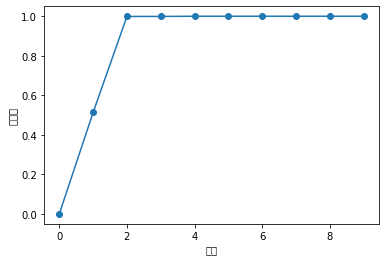

In [10]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from Chap08_Attention.attention_seq2seq import AttentionSeq2seq
from Chap07_Seq2Seq.seq2seq import Seq2seq
from Chap07_Seq2Seq.peeky_seq2seq import PeekySeq2seq


# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('정확도 %.3f%%' % (acc * 100))


model.save_params()

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()

# 어테션 가중치의 시각화

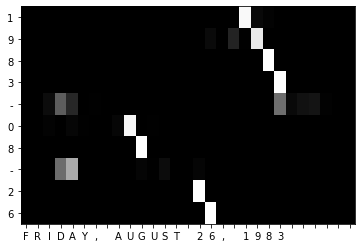

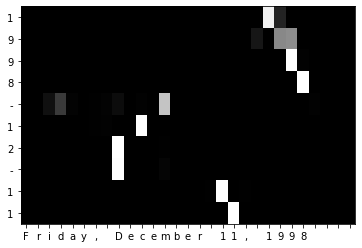

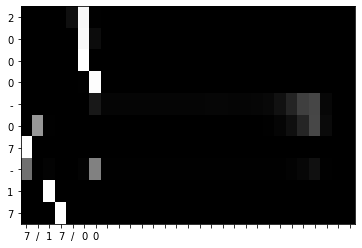

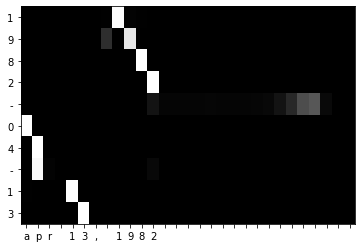

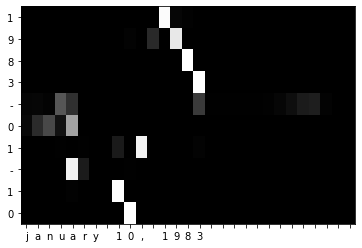

In [14]:
import sys
sys.path.append('..')
import numpy as np
from dataset import sequence
import matplotlib.pyplot as plt
from Chap08_Attention.attention_seq2seq import AttentionSeq2seq


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # 출력하기 위해 반전
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)

# 넘파이 인덱싱과 친해지기

In [12]:
import numpy as np
# 파이썬 3차원 배열 [Layer][Row][Column]

x = np.array([[[1],[2],[3]], [[4],[5],[6]]])
# ellipsis
print(x)
print(x[...,0])
print(x.shape)
print(x[1:2].shape)
print(x[1:2])
print()
print(x[0,:,0])
print(x[:, -1, :])

[[[1]
  [2]
  [3]]

 [[4]
  [5]
  [6]]]
[[1 2 3]
 [4 5 6]]
(2, 3, 1)
(1, 3, 1)
[[[4]
  [5]
  [6]]]

[1 2 3]
[[3]
 [6]]
